In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
!pip install tqdm
from tqdm import tqdm
from torchsummary import summary
import sys
import os
%matplotlib inline
import matplotlib.pyplot as plt

from model1 import *
from utils1 import *

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# To find out mean and std of the images, we comment out Normalize to get accurate mean and std
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
exp = datasets.MNIST('../data/MNIST', train=True, download=True, transform=simple_transforms)
return_image_stats(exp)

100%|██████████| 9912422/9912422 [00:00<00:00, 100717818.68it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 42955919.80it/s]


Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25331172.54it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7503162.18it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [3]:
train = datasets.MNIST('../data/MNIST', train=True, download=True, transform=train_transforms())
# The dataset named "MNIST" is being called from within the torchvision available datasets
# MNIST is a dataset containing handwritten digits
# The training part of the dataset is downloaded to ../data location
# This is also the Extract (E) part of the ETL process where we are going to extract the dataset from raw data
test = datasets.MNIST('../data/MNIST', train=False, download=True, transform=test_transforms())
# The test part of the dataset is downloaded to ../data location

In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

device = torch.device("cuda" if cuda else "cpu")

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64, num_workers=2, pin_memory=True)
# Batch Size is a tunable parameter that tells us how many images can be sent in parallel to the model.
# This depends on the available memory and can be increased/decreased accordingly. This is tuned after the model is ran and based on available memory

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
# trainloader is sort of "for" loop for us which will allow to look at or load a lot of images (~batch_size) at same time
# torch.utils.data.DataLoader wraps a dataset and provides access to the underlying data

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)
# test till help to check accuracy of our model

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
return_image_stats(train)
# Since the train data is already Normalized, we will not get the actual mean and std values

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


torch.Size([128, 1, 28, 28])
torch.Size([128])


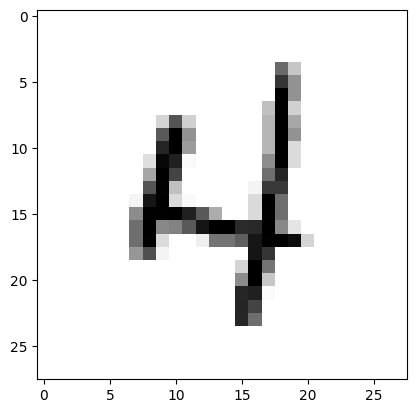

In [6]:
return_single_image(train_loader)

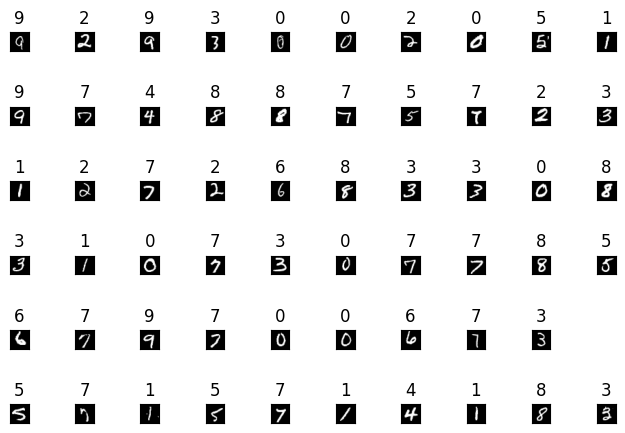

In [7]:
return_dataset_images(train_loader,60)

In [8]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

In [10]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(1, EPOCHS+1):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 1


Loss=0.1159626841545105 Batch_id=468 Accuracy=85.94: 100%|██████████| 469/469 [00:20<00:00, 23.45it/s]



Test set: Average loss: 0.0721, Accuracy: 9782/10000 (97.82%)

EPOCH: 2


Loss=0.021822182461619377 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:19<00:00, 23.53it/s]



Test set: Average loss: 0.0377, Accuracy: 9877/10000 (98.77%)

EPOCH: 3


Loss=0.0600908063352108 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:20<00:00, 22.91it/s]



Test set: Average loss: 0.0297, Accuracy: 9899/10000 (98.99%)

EPOCH: 4


Loss=0.012600735761225224 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0268, Accuracy: 9910/10000 (99.10%)

EPOCH: 5


Loss=0.026285462081432343 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:20<00:00, 23.43it/s]



Test set: Average loss: 0.0290, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.02158147655427456 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:20<00:00, 23.29it/s]



Test set: Average loss: 0.0207, Accuracy: 9933/10000 (99.33%)

EPOCH: 7


Loss=0.00757997902110219 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:20<00:00, 23.02it/s]



Test set: Average loss: 0.0286, Accuracy: 9896/10000 (98.96%)

EPOCH: 8


Loss=0.0010771190281957388 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:20<00:00, 22.41it/s]



Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 9


Loss=0.001724927220493555 Batch_id=468 Accuracy=99.77: 100%|██████████| 469/469 [00:20<00:00, 23.33it/s]



Test set: Average loss: 0.0230, Accuracy: 9923/10000 (99.23%)

EPOCH: 10


Loss=0.0056733316741883755 Batch_id=468 Accuracy=99.80: 100%|██████████| 469/469 [00:19<00:00, 23.75it/s]



Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

EPOCH: 11


Loss=0.01769995503127575 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0274, Accuracy: 9918/10000 (99.18%)

EPOCH: 12


Loss=0.000804233131930232 Batch_id=468 Accuracy=99.85: 100%|██████████| 469/469 [00:20<00:00, 22.74it/s]



Test set: Average loss: 0.0258, Accuracy: 9931/10000 (99.31%)

EPOCH: 13


Loss=0.016702016815543175 Batch_id=468 Accuracy=99.87: 100%|██████████| 469/469 [00:20<00:00, 22.52it/s]



Test set: Average loss: 0.0277, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.00016080353816505522 Batch_id=468 Accuracy=99.89: 100%|██████████| 469/469 [00:19<00:00, 23.58it/s]



Test set: Average loss: 0.0264, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=9.387979662278667e-05 Batch_id=468 Accuracy=99.90: 100%|██████████| 469/469 [00:20<00:00, 23.27it/s]



Test set: Average loss: 0.0276, Accuracy: 9927/10000 (99.27%)

EPOCH: 16


Loss=0.001101411646232009 Batch_id=468 Accuracy=99.92: 100%|██████████| 469/469 [00:20<00:00, 23.04it/s]



Test set: Average loss: 0.0277, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=9.756233339430764e-06 Batch_id=468 Accuracy=99.94: 100%|██████████| 469/469 [00:19<00:00, 23.82it/s]



Test set: Average loss: 0.0297, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=9.666383266448975e-05 Batch_id=468 Accuracy=99.95: 100%|██████████| 469/469 [00:19<00:00, 23.77it/s]



Test set: Average loss: 0.0315, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.00033746217377483845 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:20<00:00, 22.80it/s]



Test set: Average loss: 0.0287, Accuracy: 9931/10000 (99.31%)

EPOCH: 20


Loss=9.883572784019634e-05 Batch_id=468 Accuracy=99.99: 100%|██████████| 469/469 [00:20<00:00, 23.35it/s]



Test set: Average loss: 0.0312, Accuracy: 9921/10000 (99.21%)



In [11]:
train_losses

[tensor(2.3031, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3035, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3034, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3030, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3020, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2989, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2994, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2955, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2996, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2972, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2973, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2942, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2953, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

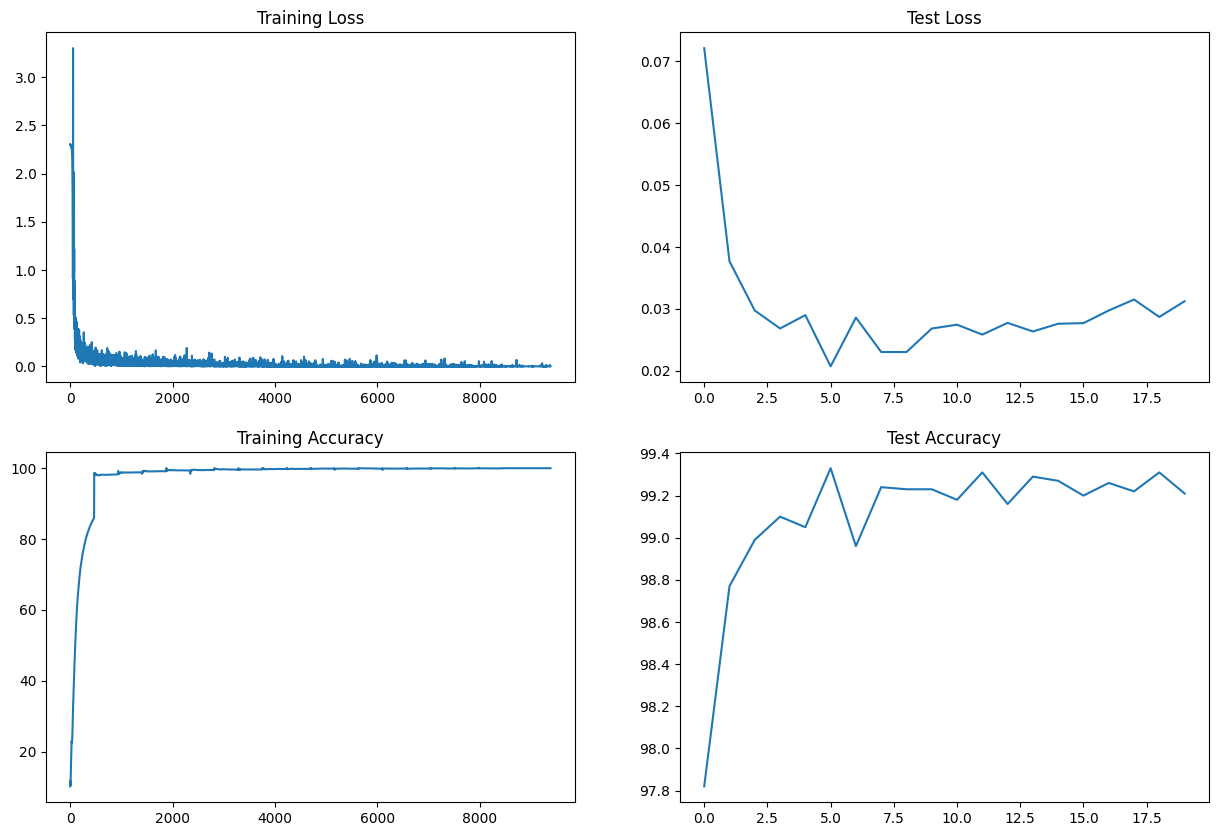

In [12]:
draw_graphs(train_losses, train_acc, test_losses, test_acc)